In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
import json
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from tifffile import imread
import struct
import pandas as pd
import cv2
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [2]:
def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

In [3]:
model = load_model(r'\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.001_epochs_400_pt_10_gaus_ratio_0')

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.001_epochs_400_pt_10_gaus_ratio_0\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6883699162882626, nms=0.3) 


In [4]:
pthHE = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles'
pthmasks = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\qupath\ground_truth\masks'

HE_tiles_pths = sorted(glob(os.path.join(pthHE,'*.tif')))
mask_tiles_pths = sorted(glob(os.path.join(pthmasks,'*.tif')))

# not done with all tiles yet
#pthHE_new = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\12_5_new_monkey_tiles'
#pthHE_new_pths = sorted(glob(os.path.join(pthHE_new,'*.tif')))
# = [os.path.basename(pth) for pth in pthHE_new_pths]
#HE_tiles_pths = [name for name in HE_tiles_pths if name[58:] not in pthHE_new_names]

print(len(HE_tiles_pths))

36


In [5]:
HE_tiles = list(map(imread,HE_tiles_pths))
mask_tiles = list(map(imread,mask_tiles_pths))

In [6]:
print(len(HE_tiles))
print(len(mask_tiles))

36
36


In [7]:
HE_tiles_default = [normalize(x) for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles_default = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

HE_tiles = [x/255 for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

In [8]:
mask_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(HE_tiles)]

100%|██████████| 36/36 [00:04<00:00,  8.73it/s]


In [9]:
#PLot image and label for some images - sanity check
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16/2, 8/2))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

Text(0.5, 1.0, 'Predicted')

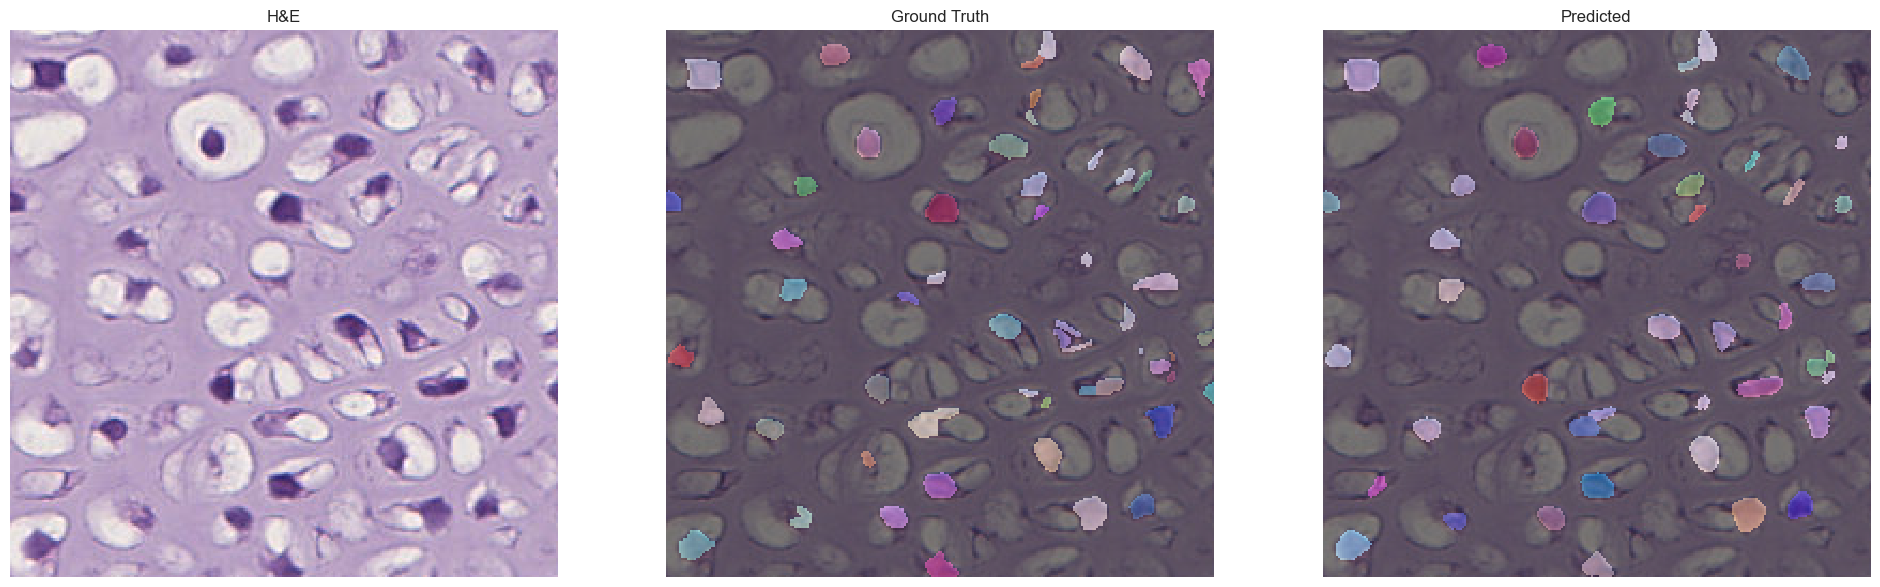

In [11]:
ind = 1

cropped_img = HE_tiles[ind]
cropped_lbl_gt = mask_tiles[ind]
cropped_lbl_pred = mask_val_pred[ind]


fig, ax = plt.subplots(1,3,figsize = (24, 8))
ax[0].imshow(cropped_img)
ax[0].axis('off')
ax[0].set_title('H&E')

ax[1].imshow(cropped_img)
ax[1].imshow(cropped_lbl_gt, cmap=lbl_cmap, alpha=0.5)
ax[1].axis('off')
ax[1].set_title('Ground Truth')

ax[2].imshow(cropped_img)
ax[2].imshow(cropped_lbl_pred, cmap=lbl_cmap, alpha=0.5)
ax[2].axis('off')
ax[2].set_title('Predicted')

In [12]:
import sys
sys.path.insert(1, r'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist\monkey')
from functions import TileSetScorer, ScoringSubroutine

nms = [os.path.basename(file) for file in HE_tiles_pths]

# taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
taus = [0.6]

scores = TileSetScorer(nms, mask_tiles, mask_val_pred, taus)

In [13]:
scores.score_set()

,Image,Tau,IoU,TP,FP,FN,Precision,Recall,Avg Precision,F1 Score,Seg Quality,Pan Quality
0,monkey_fetus_40_0272_eyes1.tif,0.6,0.756306,168,18,30,0.903226,0.848485,0.777778,0.875000,0.828186,0.724663
1,monkey_fetus_40_0273_bone.tif,0.6,0.721545,37,9,19,0.804348,0.660714,0.569231,0.725490,0.810948,0.588335
2,monkey_fetus_40_0281_eyes2.tif,0.6,0.691126,159,26,82,0.859459,0.659751,0.595506,0.746479,0.779080,0.581567
3,monkey_fetus_40_0308_liver1.tif,0.6,0.813713,142,8,13,0.946667,0.916129,0.871166,0.931148,0.848681,0.790248
4,monkey_fetus_40_0323_ears1.tif,0.6,0.690478,165,69,67,0.705128,0.711207,0.548173,0.708155,0.748207,0.529846
5,monkey_fetus_40_0344_brain1.tif,0.6,0.777257,217,25,66,0.896694,0.766784,0.704545,0.826667,0.831277,0.687189
6,monkey_fetus_40_0380_heart1.tif,0.6,0.769529,80,4,11,0.952381,0.879121,0.842105,0.914286,0.808802,0.739476
7,monkey_fetus_40_0381_thymus.tif,0.6,0.806732,141,5,28,0.965753,0.834320,0.810345,0.895238,0.840273,0.752245
8,monkey_fetus_40_0426_lungs.tif,0.6,0.713350,147,40,114,0.786096,0.563218,0.488372,0.656250,0.769545,0.505014
9,monkey_fetus_40_0428_thyroid1.tif,0.6,0.768436,104,7,19,0.936937,0.845528,0.800000,0.888889,0.836606,0.743650


In [14]:
results = scores.score_set()
names = results['Image']

names = [name.split(".")[0][21:] for name in names]

for i in range(len(names)):
    #if len(names[i]) > 6:
    names[i] = names[i][:2]

f1_scores = results['F1 Score']

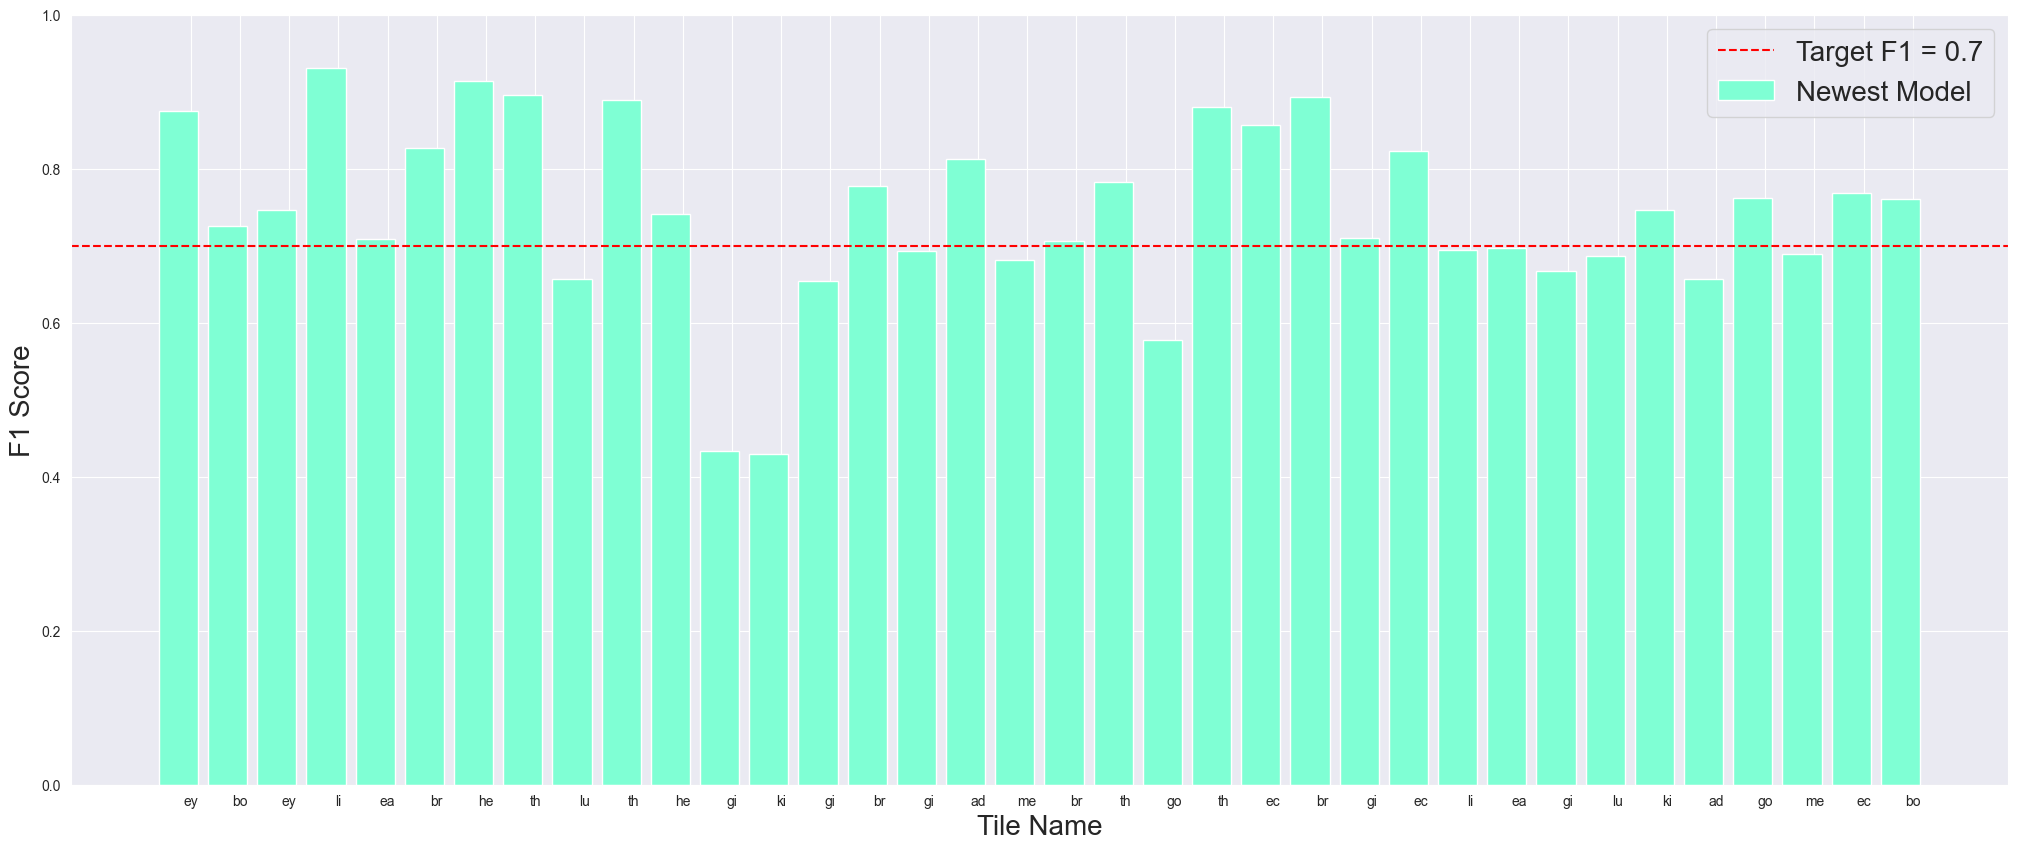

In [15]:
bar_width = 0.25  # Adjust the width of each bar as needed
index = np.arange(len(names))

# Plotting the bars
fig = plt.figure(figsize=(25, 10))
fig.set_facecolor('white')

plt.bar(index, f1_scores, color='aquamarine', label='Newest Model')

#plt.bar(index, f1_scores, color='blue', width=bar_width, label='Newest Model')
#plt.bar(index + bar_width, f1_scores_justin, color='orange', width=bar_width, label="Previous model")
#plt.bar(index + 2 * bar_width, f1_scores_default, color='green', width=bar_width, label='Default H&E')

plt.xlabel("Tile Name", fontsize=20)
plt.ylabel("F1 Score", fontsize=20)
# plt.title("F1 Scores in Testing Tiles (tau = 0.6)", fontsize=28)
plt.axhline(y=0.7, linestyle='--', color='red', label='Target F1 = 0.7')
plt.ylim(0, 1)
plt.xticks(index + bar_width, names)  # Set x-axis labels to tile names
plt.legend(fontsize=20)
plt.show()

In [16]:
results[['Image', 'F1 Score']]

,Image,F1 Score
0,monkey_fetus_40_0272_eyes1.tif,0.875000
1,monkey_fetus_40_0273_bone.tif,0.725490
2,monkey_fetus_40_0281_eyes2.tif,0.746479
3,monkey_fetus_40_0308_liver1.tif,0.931148
4,monkey_fetus_40_0323_ears1.tif,0.708155
5,monkey_fetus_40_0344_brain1.tif,0.826667
6,monkey_fetus_40_0380_heart1.tif,0.914286
7,monkey_fetus_40_0381_thymus.tif,0.895238
8,monkey_fetus_40_0426_lungs.tif,0.656250
9,monkey_fetus_40_0428_thyroid1.tif,0.888889


In [17]:
raw_vals = results[['Image', 'TP', 'FP', 'FN']]
raw_vals

,Image,TP,FP,FN
0,monkey_fetus_40_0272_eyes1.tif,168,18,30
1,monkey_fetus_40_0273_bone.tif,37,9,19
2,monkey_fetus_40_0281_eyes2.tif,159,26,82
3,monkey_fetus_40_0308_liver1.tif,142,8,13
4,monkey_fetus_40_0323_ears1.tif,165,69,67
5,monkey_fetus_40_0344_brain1.tif,217,25,66
6,monkey_fetus_40_0380_heart1.tif,80,4,11
7,monkey_fetus_40_0381_thymus.tif,141,5,28
8,monkey_fetus_40_0426_lungs.tif,147,40,114
9,monkey_fetus_40_0428_thyroid1.tif,104,7,19


In [18]:
def find_first_unique_indices(lst):
    unique_indices = {}
    result = []

    for i, value in enumerate(lst):
        if value not in unique_indices:
            unique_indices[value] = i

    for value in lst:
        result.append(unique_indices[value])

    return result

result_list = find_first_unique_indices(names)
print(result_list)

[0, 1, 0, 3, 4, 5, 6, 7, 8, 7, 6, 11, 12, 11, 5, 11, 16, 17, 5, 7, 20, 7, 22, 5, 11, 22, 3, 4, 11, 8, 12, 16, 20, 17, 22, 1]


In [19]:
print(len(np.unique(result_list)))
print(len(names))

14
36


In [20]:
print([names[i] for i in np.unique(result_list)])

['ey', 'bo', 'li', 'ea', 'br', 'he', 'th', 'lu', 'gi', 'ki', 'ad', 'me', 'go', 'ec']


In [21]:
len(raw_vals)

36

In [22]:
seen = []
names = []

TPs = [0 for _ in range(len(raw_vals))]
FPs = [0 for _ in range(len(raw_vals))]
FNs = [0 for _ in range(len(raw_vals))]

for i in range(len(raw_vals)):
    row = raw_vals.iloc[i]
    #print(num)
    num = result_list[i]
    if num not in seen:
        names.append(raw_vals['Image'][i])
        seen.append(num)

    TPs[num] += row['TP']
    FPs[num] += row['FP']
    FNs[num] += row['FN']

In [23]:
TPs

[327,
 110,
 0,
 276,
 255,
 828,
 210,
 598,
 241,
 0,
 0,
 580,
 284,
 0,
 0,
 0,
 190,
 203,
 0,
 0,
 285,
 0,
 186,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [24]:
raw_vals

,Image,TP,FP,FN
0,monkey_fetus_40_0272_eyes1.tif,168,18,30
1,monkey_fetus_40_0273_bone.tif,37,9,19
2,monkey_fetus_40_0281_eyes2.tif,159,26,82
3,monkey_fetus_40_0308_liver1.tif,142,8,13
4,monkey_fetus_40_0323_ears1.tif,165,69,67
5,monkey_fetus_40_0344_brain1.tif,217,25,66
6,monkey_fetus_40_0380_heart1.tif,80,4,11
7,monkey_fetus_40_0381_thymus.tif,141,5,28
8,monkey_fetus_40_0426_lungs.tif,147,40,114
9,monkey_fetus_40_0428_thyroid1.tif,104,7,19


In [25]:
print(names)
print(TPs)

['monkey_fetus_40_0272_eyes1.tif', 'monkey_fetus_40_0273_bone.tif', 'monkey_fetus_40_0308_liver1.tif', 'monkey_fetus_40_0323_ears1.tif', 'monkey_fetus_40_0344_brain1.tif', 'monkey_fetus_40_0380_heart1.tif', 'monkey_fetus_40_0381_thymus.tif', 'monkey_fetus_40_0426_lungs.tif', 'monkey_fetus_40_0452_gi1.tif', 'monkey_fetus_40_0471_kidney.tif', 'monkey_fetus_40_0502_adrenal.tif', 'monkey_fetus_40_0505_mesokidney.tif', 'monkey_fetus_40_0526_gonads.tif', 'monkey_fetus_40_0601_ecm1.tif']
[327, 110, 0, 276, 255, 828, 210, 598, 241, 0, 0, 580, 284, 0, 0, 0, 190, 203, 0, 0, 285, 0, 186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [26]:
print(len(names))

14


In [27]:
organ_names = []
for i in range(len(names)):
    nm = names[i][21:-4]
    if nm[-1] == '1':
        nm = nm[:-1]
    organ_names.append(nm)
    print(nm)

eyes
bone
liver
ears
brain
heart
thymus
lungs
gi
kidney
adrenal
mesokidney
gonads
ecm


In [28]:
print(len(organ_names))

14


In [29]:
organ_names

['eyes',
 'bone',
 'liver',
 'ears',
 'brain',
 'heart',
 'thymus',
 'lungs',
 'gi',
 'kidney',
 'adrenal',
 'mesokidney',
 'gonads',
 'ecm']

In [30]:
TPs = [val for val in TPs if val != 0]
FPs = [val for val in FPs if val != 0]
FNs = [val for val in FNs if val != 0]

In [31]:
len(TPs)

14

In [32]:
new_df = pd.DataFrame({'Organ': organ_names, 'TP': TPs, 'FP': FPs, 'FN': FNs})
new_df

,Organ,TP,FP,FN
0,eyes,327,44,112
1,bone,110,18,56
2,liver,276,43,96
3,ears,255,89,125
4,brain,828,137,293
5,heart,210,38,68
6,thymus,598,59,146
7,lungs,241,63,177
8,gi,580,204,484
9,kidney,284,122,236


In [33]:
def get_f1(tp, fp, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    avg_precision = tp / (tp + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, avg_precision, f1

In [34]:
precisions = []
recalls = []
f1s = []

for i in range(len(new_df)):
    row = new_df.iloc[i]

    tp = row['TP']
    fp = row['FP']
    fn = row['FN']

    precision, recall, avg_precision, f1 = get_f1(tp, fp, fn)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

In [35]:
row = new_df.iloc[11]

tp = row['TP']
fp = row['FP']
fn = row['FN']
print([tp, fp, fn])

[203, 68, 119]


In [36]:
new_df['Recall'] = recalls
new_df['Precision'] = precisions
new_df['F1'] = f1s

new_df

,Organ,TP,FP,FN,Recall,Precision,F1
0,eyes,327,44,112,0.744875,0.881402,0.807407
1,bone,110,18,56,0.662651,0.859375,0.748299
2,liver,276,43,96,0.741935,0.865204,0.798842
3,ears,255,89,125,0.671053,0.741279,0.704420
4,brain,828,137,293,0.738626,0.858031,0.793864
5,heart,210,38,68,0.755396,0.846774,0.798479
6,thymus,598,59,146,0.803763,0.910198,0.853676
7,lungs,241,63,177,0.576555,0.792763,0.667590
8,gi,580,204,484,0.545113,0.739796,0.627706
9,kidney,284,122,236,0.546154,0.699507,0.613391


In [46]:
#print(sum(new_df['TP']))
#print(sum(new_df['FP']))
#print(sum(new_df['FN']))

print(sum(new_df['TP'])+sum(new_df['FP'])+sum(new_df['FN']))

7862


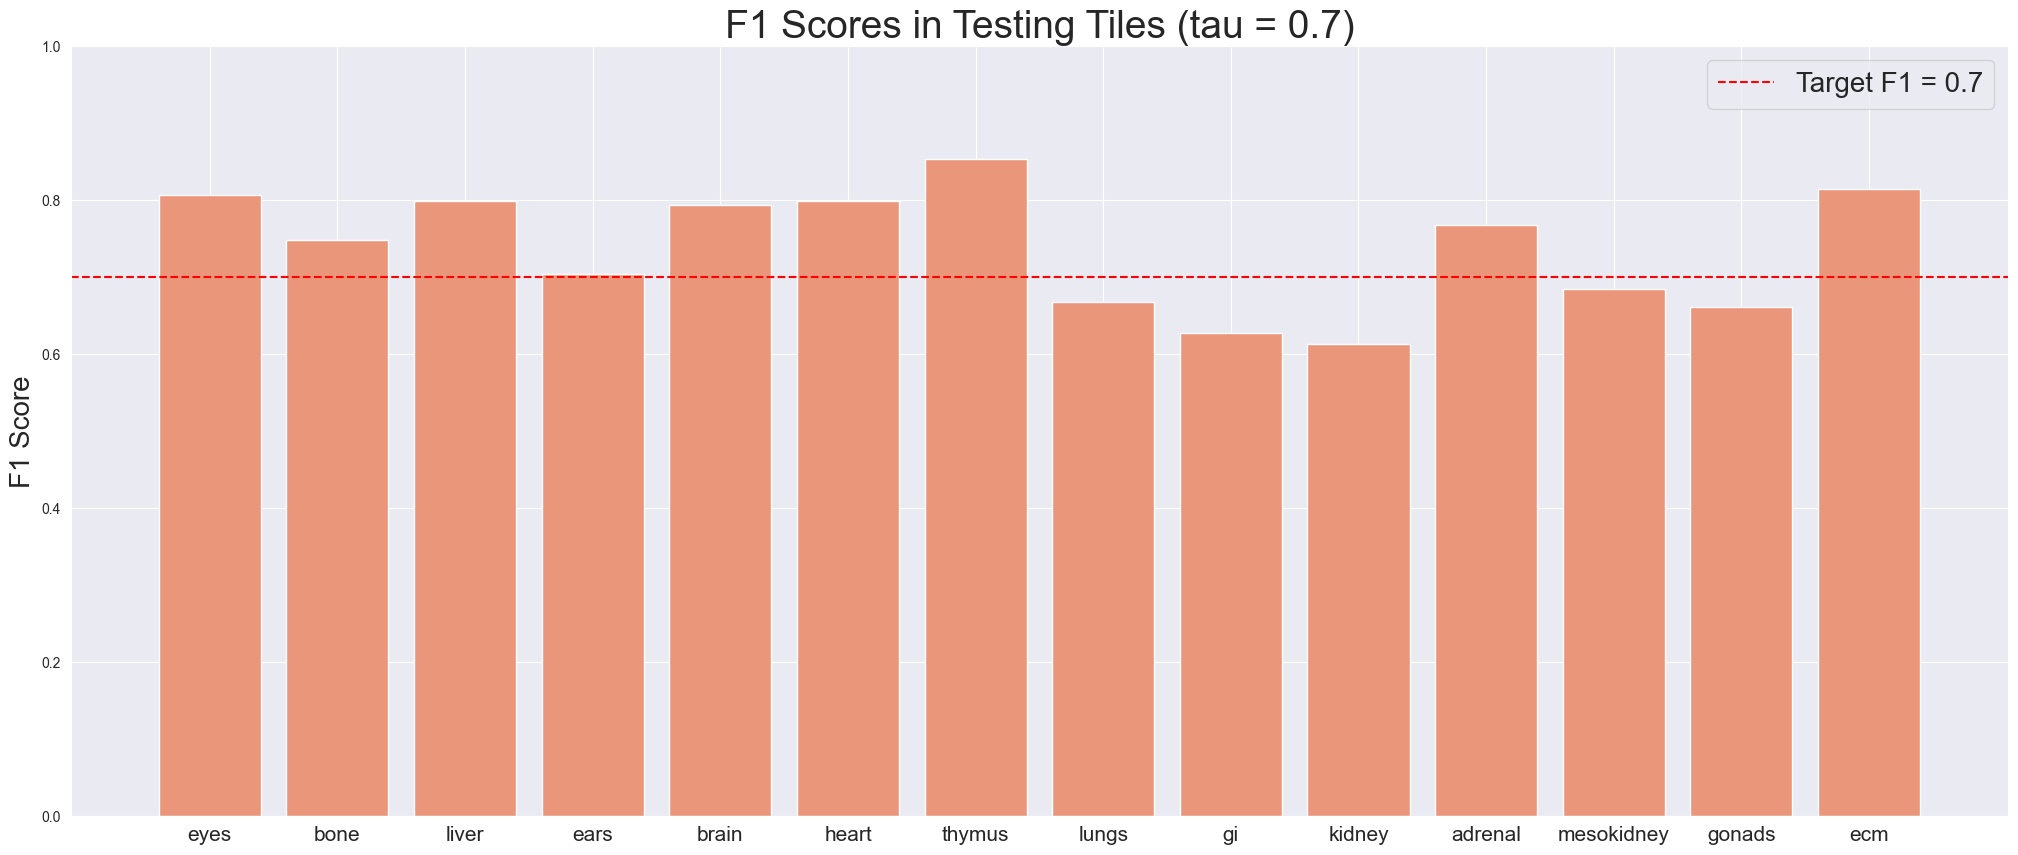

In [37]:
bar_width = 0.25  # Adjust the width of each bar as needed
index = np.arange(len(new_df['Organ']))

# Plotting the bars
fig = plt.figure(figsize=(25, 10))
fig.set_facecolor('white')

plt.bar(new_df['Organ'], new_df['F1'], color='darksalmon') #, label='Newest Model')

#plt.bar(index, f1_scores, color='blue', width=bar_width, label='Newest Model')
#plt.bar(index + bar_width, f1_scores_justin, color='orange', width=bar_width, label="Previous model")
#plt.bar(index + 2 * bar_width, f1_scores_default, color='green', width=bar_width, label='Default H&E')

# plt.xlabel("Organ", fontsize=20)
plt.ylabel("F1 Score", fontsize=20)
plt.title("F1 Scores in Testing Tiles (tau = 0.7)", fontsize=28)
plt.axhline(y=0.7, linestyle='--', color='red', label='Target F1 = 0.7')
plt.ylim(0, 1)
plt.xticks(index, new_df['Organ'], fontsize = 15)  # Set x-axis labels to tile names
plt.legend(fontsize=20)
plt.show()

In [51]:
model

StarDist2D(offshoot_model): YXC → YXC
├─ Directory: \\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.001_epochs_400_pt_10_gaus_ratio_0\offshoot_model
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 3], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=[1, 1], train_epochs=400

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (14,) and arg 1 with shape (36,).

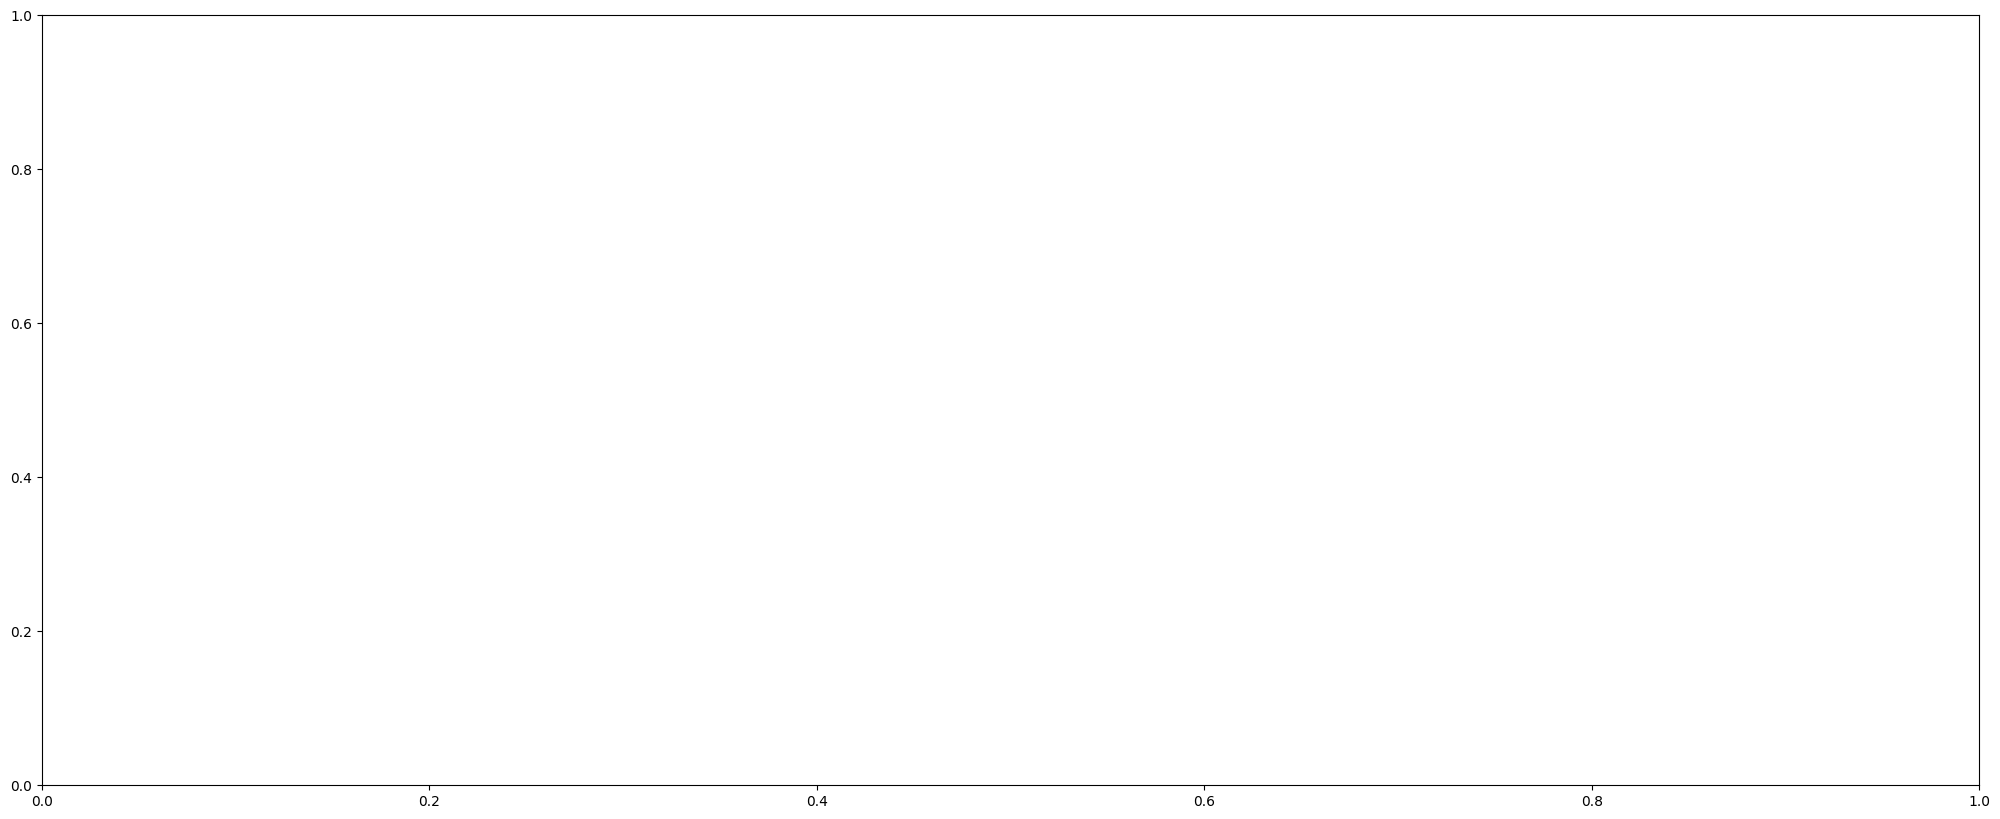

In [52]:
bar_width = 0.25  # Adjust the width of each bar as needed
index = np.arange(len(names))

# Plotting the bars
fig = plt.figure(figsize=(25, 10))
fig.set_facecolor('white')

plt.bar(index, f1_scores, color='blue', label='Newest Model')


plt.xlabel("Tile Name", fontsize=20)
plt.ylabel("F1 Score", fontsize=20)
# plt.title("F1 Scores in Testing Tiles (tau = 0.6)", fontsize=28)
plt.axhline(y=0.7, linestyle='--', color='red', label='Threshold = 0.7')
plt.ylim(0, 1)
plt.xticks(index + bar_width, names)  # Set x-axis labels to tile names
plt.legend(fontsize=20)
plt.show()

In [ ]:
from scoring_for_donald import TileSetScorer, ScoringSubroutine

In [ ]:
def calc_iou_for_each_nucleus(masks1, masks2) -> list[float]:
    iou_scores = []

    for mask1, mask2 in zip(masks1, masks2):
        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        intersection_area = np.sum(intersection)
        union_area = np.sum(union)

        if union_area > 0:
            iou = intersection_area / union_area
            iou_scores.append(iou)
        else:
            iou_scores.append(0.0)

    return iou_scores

In [ ]:
test_gt = mask_tiles[0]
test_pred = mask_val_pred[0]

test_iou = calc_iou_for_each_nucleus(test_gt, test_pred)
print(test_iou)

In [ ]:
def plot_masks(masks1: list[np.ndarray], masks2: list[np.ndarray]):
    num_masks1 = len(masks1)
    num_masks2 = len(masks2)

    fig, axs = plt.subplots(num_masks1, num_masks2, figsize=(12, 8))

    for i in range(num_masks1):
        for j in range(num_masks2):
            axs[i, j].imshow(masks1[i], cmap='Blues', alpha=0.5)
            axs[i, j].imshow(masks2[j], cmap='Reds', alpha=0.5)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])

    # Add legends
    axs[0, 0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.tight_layout()
    plt.show()

plot_masks(test_gt, test_pred)

In [ ]:
for i, mask1 in enumerate(masks_nuclei1):
    for j, mask2 in enumerate(masks_nuclei2):
        iou_matrix[i, j] = calc_iou_for_each_nucleus([mask1], [mask2])[0]

plot_iou_heatmap(iou_matrix, labels1=['Nucleus 1', 'Nucleus 2', ...], labels2=['Nucleus 1', 'Nucleus 2', ...])